In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-30 15:06:23,496 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
2025-01-30 15:06:23,496 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
2025-01-30 15:06:23,497 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [2]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data = data[0]
data_df

,,sum_terminals
one_time,township_name,
2021-09-15 00:00:00,Avenidas Novas,260700.0
2021-09-15 01:00:00,Avenidas Novas,276675.0
2021-09-15 02:00:00,Avenidas Novas,284563.0
2021-09-15 03:00:00,Avenidas Novas,279563.0
2021-09-15 04:00:00,Avenidas Novas,281460.0
...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0
2021-11-30 20:00:00,Avenidas Novas,352361.0
2021-11-30 21:00:00,Avenidas Novas,388246.0


In [3]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = STUMPY_EXCL_ZONE_DENOM  

for m in SUBSQUENCES_LENGTHS:
    out = stumpy.stump(data, m, normalize=NORMALIZE)
    np.save(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp.npy",
        out.P_,
        allow_pickle=True,
    )

2025-01-30 15:06:25,231 - INFO - init


In [4]:

def table_summary_motifs(
    motif_indices,
    motif_distances,
    data,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = 1, len(data)


    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = [0]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        med_dist = np.median(match_distances[1:])


        stats_df = {
            "ID": str(motif_index),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3)
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [5]:
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = 1

# Initialize mp_stats_table outside the loop to accumulate results
mp_stats_table = pd.DataFrame()

for m in SUBSQUENCES_LENGTHS:
    mp = np.load(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp.npy",
        allow_pickle=True,
    )

    motif_distances, motif_indices = stumpy.motifs(
        data,
        mp,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoff=cutoff,
        max_matches=max_matches,
        max_motifs=max_motifs,
        normalize=NORMALIZE,
    )
    if len(motif_indices[0]) == 0:
        continue

    # Create the table for the current iteration
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        data,
        m,
        NORMALIZE,
        max_distance,
    )

    # Append the current table to mp_stats_table
    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

# Save the accumulated mp_stats_table to CSV
mp_stats_table.to_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv",
    index=False,
)

In [6]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(
    columns=[
        "m",
        "#motifs",
        "avg_n_matches"
    ]
)
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]

    avg_n_matches = (
        round(table["#Matches"].mean(), 2),
        round(table["#Matches"].std(), 3),
    )

    stats_df = {
        "m": m,
        "#motifs": n_motifs,
        "avg_n_matches": avg_n_matches
    }

    motif_stats_table = (
        pd.DataFrame.from_records([stats_df])
        if motif_stats_table.empty
        else pd.concat(
            [motif_stats_table, pd.DataFrame.from_records([stats_df])],
            ignore_index=True,
        )
    )

print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrl}
\toprule
m & #motifs & avg_n_matches \\
\midrule
12 & 28 & (20.61, 15.428) \\
\bottomrule
\end{tabular}



In [7]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)

subsequence_lengths = mp_stats_table["m"].unique()
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="#Matches", ascending=False).head(5)
    top_motifs = top_motifs[
        [
            "ID",
            "#Matches",
            "max(dists)",
            "min(dists)",
        ]
    ]
    print(top_motifs.to_latex(index=False, float_format="%.3f"))
    print("\n")

########## m:12 #########
\begin{tabular}{rrrr}
\toprule
ID & #Matches & max(dists) & min(dists) \\
\midrule
26 & 57 & 2.958 & 2.095 \\
5 & 46 & 1.162 & 0.371 \\
23 & 45 & 2.962 & 1.731 \\
11 & 43 & 1.353 & 0.755 \\
6 & 37 & 1.291 & 0.542 \\
\bottomrule
\end{tabular}





In [8]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / f"{motif_name}.png")
  
    return None

Motif length:  12
    ID   m  #Matches                                            Indices  \
26  26  12        57  [1759, 174, 1303, 1063, 1709, 580, 726, 343, 1...   
5    5  12        46  [863, 359, 167, 119, 311, 287, 719, 791, 1175,...   
23  23  12        45  [1272, 284, 1198, 1147, 1029, 743, 1247, 957, ...   
11  11  12        43  [1752, 240, 1150, 143, 960, 1222, 887, 382, 21...   
6    6  12        37  [1254, 1517, 1325, 1540, 317, 1804, 125, 1564,...   

    max(dists)  min(dists)  med(dists)  
26       2.958       2.095       2.590  
5        1.162       0.371       0.785  
23       2.962       1.731       2.650  
11       1.353       0.755       1.188  
6        1.291       0.542       1.033  


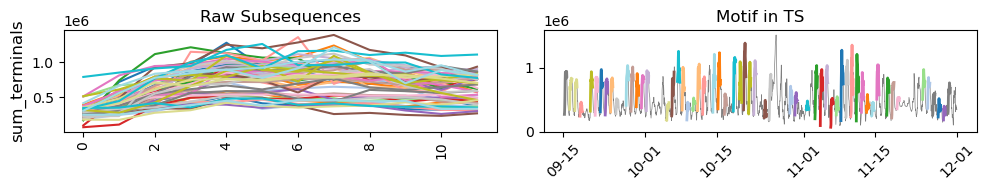

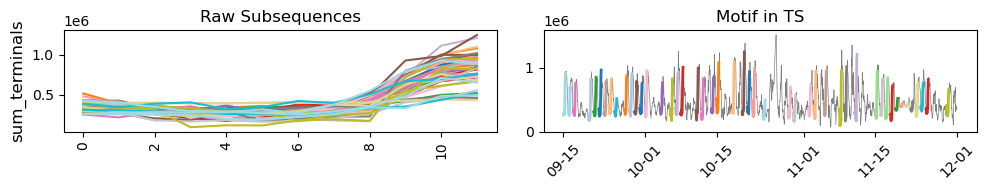

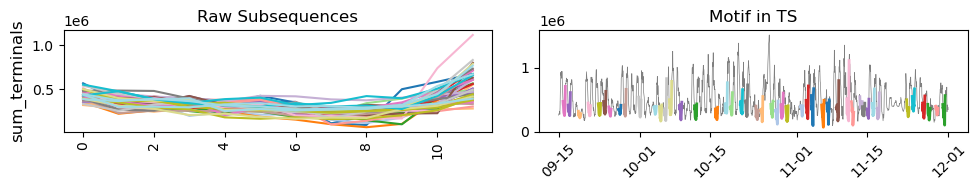

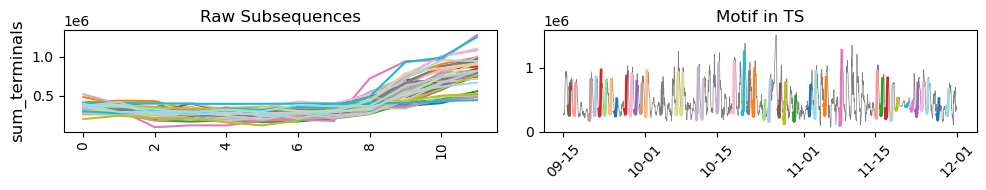

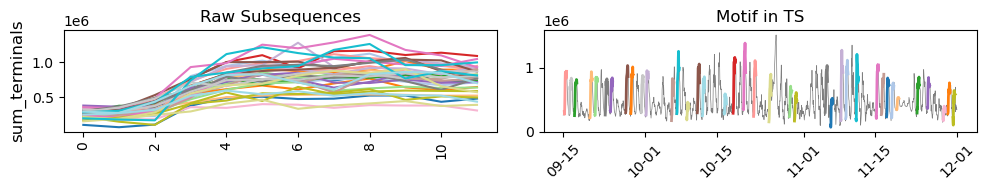

In [9]:
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="#Matches", ascending=False).head(5)
    print( top_motifs)
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        features = VARIABLES 
        ts_list = [
            data_df.reset_index()[[feature] + ["one_time"]].set_index(["one_time"])
            for feature in features
        ]
        plot_motif(ts_list, features, m, indices, motif_name)